# **Music Recommendation System**
**REPO VERSION**

## **MILESTONE I**

### **Problem Definition**

**The context** - Why is this problem important to solve?<br>
**The objectives** - What is the intended goal?<br>
**The key questions** - What are the key questions that need to be answered?<br>
**The problem formulation** - What is it that we are trying to solve using data science?


### **Data Dictionary**

The core data is the Taste Profile Subset released by The Echo Nest as part of the Million Song Dataset. There are two files in this dataset. One contains the details about the song id, titles, release, artist name and the year of release. Second file contains the user id, song id and the play count of users.

song_data

song_id - A unique id given to every song

title - Title of the song

Release - Name of the released album

Artist_name - Name of the artist 

year - Year of release

count_data

user _id - A unique id given to the user

song_id - A unique id given to the song

play_count - Number of times the song was played

### **Data Source**
http://millionsongdataset.com/

##### **Importing Libraries**

In [96]:
import warnings # ignore the warning given as output of the code
warnings.filterwarnings('ignore')
%matplotlib inline

import numpy as np # libraries of python for numeric and dataframe computations
import pandas as pd
import random 

import matplotlib.pyplot as plt # library for data visualization

import seaborn as sns # advanced library for data visualization

from sklearn.metrics.pairwise import cosine_similarity # compute the cosine similarity between two vectors
from collections import defaultdict # dictionary output that does not raise a key error

from sklearn.metrics import mean_squared_error # performance metrics in sklearn

from sklearn import preprocessing # for embedding encrypted data

# for word2vec recommendation
from tqdm import tqdm
from gensim.models import Word2Vec

# for dimensional reduction
import umap.umap_ as umap


In [98]:
import gensim
print(gensim.__version__)

3.8.3


In [99]:
print(np.__version__)

1.22.1


In [101]:
!python --version

Python 3.9.9


##### **Loading Dataset**

In [102]:
# import the datasets
count_df = pd.read_csv('/Users/student/Downloads/count_data.csv')
song_df = pd.read_csv('/Users/student/Downloads/song_data.csv')

In [103]:
# copy data to another dataframe
count_df_copy = count_df.copy(deep=True)
song_df_copy = song_df.copy(deep=True)

In [104]:
song_df.head()

,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0


**Observations**
- The song_df needs data embedding.
- There are features with missing values, which will need correction. 

In [105]:
count_df.head()

,Unnamed: 0,user_id,song_id,play_count
0,0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1


In [106]:
# drop the column 'Unnamed: 0'  
count_df.drop(['Unnamed: 0'], 
                axis = 1, 
                inplace = True)


In [107]:
count_df.head()

,user_id,song_id,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1


In [108]:
# fill null values in song_df with fillna()
song_df = song_df.fillna(value=0)

In [109]:
# apply label encoding for "song_id"
encoded_song_id =  preprocessing.LabelEncoder()
encoded_song_id.fit(song_df.song_id)
song_df.song_id = encoded_song_id.transform(song_df.song_id)
count_df.song_id = encoded_song_id.transform(count_df.song_id)

# apply label encoding for "user_id"
encoded_user_id =  preprocessing.LabelEncoder()
count_df.user_id = encoded_user_id.fit_transform(count_df.user_id)


In [110]:
# left merge the count_df and song_df data on "song_id". Drop duplicates from song_df data simultaneously.
merged_df = count_df.merge(song_df.drop_duplicates(['song_id']), 
                            how='left', 
                            on='song_id')

In [111]:
merged_df.head()

,user_id,song_id,play_count,title,release,artist_name,year
0,54961,17370,1,The Cove,Thicker Than Water,Jack Johnson,0
1,54961,45995,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,54961,82002,1,Stronger,Graduation,Kanye West,2007
3,54961,83689,1,Constellations,In Between Dreams,Jack Johnson,2005
4,54961,129375,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


**Observations** 
- One users can have multiple song_id, but only a single user_id. 
- There may be many unique values in the dataset. 

In [112]:
merged_df.describe(include = [np.int, np.object_])

,user_id,song_id,play_count,title,release,artist_name,year
count,2.000000e+06,2.000000e+06,2.000000e+06,2000000,2000000,2000000,2.000000e+06
unique,NaN,NaN,NaN,9567,5388,3375,NaN
top,NaN,NaN,NaN,Sehr kosmisch,Greatest Hits,Coldplay,NaN
freq,NaN,NaN,NaN,8277,15692,29422,NaN
mean,3.813599e+04,5.097695e+05,3.045485e+00,NaN,NaN,NaN,1.628645e+03
std,2.204443e+04,2.863777e+05,6.579720e+00,NaN,NaN,NaN,7.787283e+02
min,0.000000e+00,1.900000e+01,1.000000e+00,NaN,NaN,NaN,0.000000e+00
25%,1.911200e+04,2.622680e+05,1.000000e+00,NaN,NaN,NaN,1.984000e+03
50%,3.794900e+04,5.232100e+05,1.000000e+00,NaN,NaN,NaN,2.002000e+03
75%,5.713500e+04,7.603520e+05,3.000000e+00,NaN,NaN,NaN,2.007000e+03


In [113]:
song_df.fillna(value=0)

,song_id,title,release,artist_name,year
0,664054,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,834264,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,286654,No One Could Ever,Butter,Hudson Mohawke,2006
3,66717,Si Vos Querés,De Culo,Yerba Brava,2003
4,324820,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0
...,...,...,...,...,...
999995,787007,O Samba Da Vida,Pacha V.I.P.,Kiko Navarro,0
999996,919087,Jago Chhadeo,Naale Baba Lassi Pee Gya,Kuldeep Manak,0
999997,318719,Novemba,Dub_Connected: electronic music,Gabriel Le Mar,0
999998,491369,Faraday,The Trance Collection Vol. 2,Elude,0


In [114]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000000 entries, 0 to 1999999
Data columns (total 7 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      int64 
 1   song_id      int64 
 2   play_count   int64 
 3   title        object
 4   release      object
 5   artist_name  object
 6   year         int64 
dtypes: int64(4), object(3)
memory usage: 122.1+ MB


**As this dataset is very large and has 2,000,000 observations, it is not computationally possible to build a model using this. Moreover, there are many users who had a single interaction with a single song and users who had multiple interactions with a single song. It is necessary to reduce the dataset by considering certain logical assumptions.**

In [115]:
# get the column containing the users 
users = merged_df.user_id 
# create dictionary from users to their number of ratings
user_ratings_count = dict()
for user in users:
    # if there is alreay a user, just add 1 to the rating
    if user in user_ratings_count:
        user_ratings_count[user] +=1
        # otherwise set the rating count to 1
    else:
        user_ratings_count[user] = 1


In [116]:
# set a threshold of users' listen counts to at least 90 songs 
RATINGS_CUTOFF = 90
remove_users = []
def ratings_cutoff():
    for user, num_ratings in user_ratings_count.items():
        if num_ratings < RATINGS_CUTOFF:
            remove_users.append(user)
    df_final = merged_df.loc[~merged_df.user_id.isin(remove_users)]

In [117]:
# get the column containing the users
users = merged_df.song_id
# create a dictionary from users to their number of songs
song_ratings_count = dict()
for user in users:
    # if we already have the user, just add 1 to their rating count
    if user in song_ratings_count:
        song_ratings_count[user] += 1
    # otherwise, set their rating count to 1
    else:
        song_ratings_count[user] = 1    

In [118]:
# set a threshold of users' listen counts to at least 120 songs 
RATINGS_CUTOFF = 120
remove_users = []
for user, num_ratings in song_ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
df_final= merged_df.loc[~merged_df.song_id.isin(remove_users)]


In [119]:
df_final.head(100)

,user_id,song_id,play_count,title,release,artist_name,year
0,54961,17370,1,The Cove,Thicker Than Water,Jack Johnson,0
1,54961,45995,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,54961,82002,1,Stronger,Graduation,Kanye West,2007
3,54961,83689,1,Constellations,In Between Dreams,Jack Johnson,2005
4,54961,129375,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999
...,...,...,...,...,...,...,...
114,47087,105685,2,Life In Technicolor,Viva La Vida Or Death And All His Friends,Coldplay,2008
115,47087,122206,2,Clocks,A Rush Of Blood To The Head,Coldplay,2002
116,47087,208426,2,Strawberry Swing,Viva La Vida - Prospekt's March Edition,Coldplay,2008
117,47087,341214,4,Life In Technicolor ii,Viva La Vida - Prospekt's March Edition,Coldplay,2008


**Observations**
- There are seven columns in the new merged and organized dataset. 
- There may be many users who have played a song only one time. 
- Some users played a song multiple times. 

In [120]:
# fill null values 
df_final.fillna(value=0)

,user_id,song_id,play_count,title,release,artist_name,year
0,54961,17370,1,The Cove,Thicker Than Water,Jack Johnson,0
1,54961,45995,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,54961,82002,1,Stronger,Graduation,Kanye West,2007
3,54961,83689,1,Constellations,In Between Dreams,Jack Johnson,2005
4,54961,129375,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999
...,...,...,...,...,...,...,...
1999994,64590,359346,4,Unwell (Album Version),More Than You Think You Are,matchbox twenty,2003
1999995,64590,385009,2,Ignorance (Album Version),Ignorance,Paramore,0
1999996,64590,392598,4,Two Is Better Than One,Love Drunk,Boys Like Girls featuring Taylor Swift,2009
1999997,64590,393702,3,What I've Done (Album Version),What I've Done,Linkin Park,2007


In [121]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1575883 entries, 0 to 1999998
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   user_id      1575883 non-null  int64 
 1   song_id      1575883 non-null  int64 
 2   play_count   1575883 non-null  int64 
 3   title        1575883 non-null  object
 4   release      1575883 non-null  object
 5   artist_name  1575883 non-null  object
 6   year         1575883 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 96.2+ MB


- The df_final dataset is very large and has 1,575,883 observations.
- It is difficult computationally build a model using this dataset at that size.
- The dataset should be somewhat reduced and normalized. 

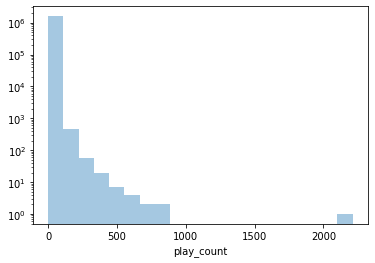

In [122]:
# histogram for play_count in log scale
df_final.fillna(value=0)
play_count_histogram = sns.distplot(df_final.play_count, kde=False, rug=False, bins=20)
play_count_histogram.set_yscale('log')

**Observations**
- There are lots of single users who have only played a song once. 
- The data also has some users who have played a song over 2000 times, and this seems odd. 
- The data is right skewed, suggesting that some values are driving the mean up. 

##### **Exploratory Data Analysis**

**Shape of the Data**

In [123]:
# check the data types 
df_final.dtypes

user_id         int64
song_id         int64
play_count      int64
title          object
release        object
artist_name    object
year            int64
dtype: object

In [124]:
# number of unique values in the df_final
df_final.nunique()

user_id        75579
song_id         5229
play_count       282
title           5082
release         3044
artist_name     1970
year              57
dtype: int64

**Observations**
- There are a lot of unique values in the df_final dataset. 
- Look into the specifics of the values that are unique.

**Is there a song that has been interacted with more than once by the same user?**

In [125]:
df_final.groupby(['user_id', 'song_id']).sum()

play_count  year
user_id song_id                  
0       392231            1  2003
        541321            3     0
        843090            1  2003
        889862            3     0
1       275060            1  1984
...                     ...   ...
76352   792989            1  2005
        846781            1  2005
        850320            1  2005
        866899            1  2005
        981573            1  2001

[1575883 rows x 2 columns]

In [126]:
df_final.groupby(['user_id', 'song_id']).count()['play_count'].sum()

1575883

**Oberservations**
- The sum of songs associated with a user_id is equal to the total number of observations. 
- This implies that there are only interactions between a pair of songs and a single user. 

In [127]:
# the most listened to song
df_final['song_id'].value_counts()

241964    8277
35140     7032
38957     6949
67669     6412
751776    6145
          ... 
851645     120
63568      120
925413     120
294490     120
153817     120
Name: song_id, Length: 5229, dtype: int64

**Observations** 
- User with the id = 241964 has the highest count of song at ~8277. 

In [128]:
df_final['user_id'].nunique()

75579

In [129]:
df_final['song_id'].nunique()

5229

**Observations**
- The song with song_id 241964 has been interacted with the most at 8277 times.
- There is a possibility that 75579 * 5229 = 395202591 interactions in the dataset. 
- Yet, we only have 1575883 entries, which might suggest that there are different users who interacted with a single song.
- It is noteworthy that multiple interactions for one song from various users is not a succinct indicator of popularity. 
- Just because a song received multiple interactions, does not mean that it is the song that should be recommended to users: there are many factors to consider. 
- A recommendation system that 

**Check for missing values**

In [130]:
df_final.isnull().sum()

user_id        0
song_id        0
play_count     0
title          0
release        0
artist_name    0
year           0
dtype: int64

**Summary Statistics**

In [131]:
# summary statistics of 'play_count' variable 
df_final['play_count'].describe()

count    1.575883e+06
mean     3.109813e+00
std      6.770442e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      2.213000e+03
Name: play_count, dtype: float64

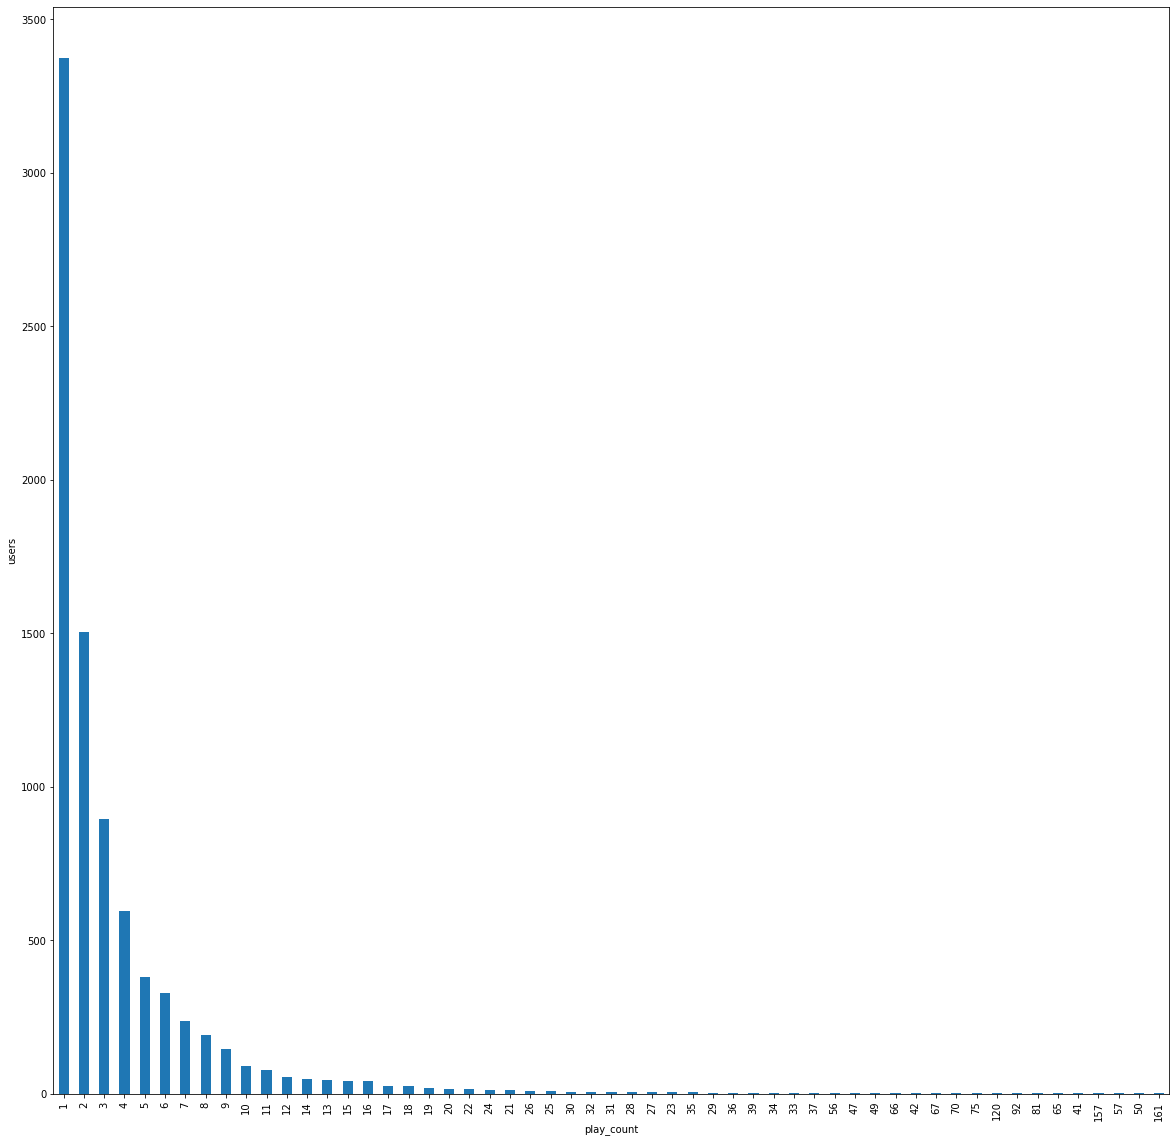

In [132]:
# create the bar plot and provide observations
# given a most liked or most disliked product

plt.figure(figsize = (20,20))
df_final[df_final['song_id'] == 241964]['play_count'].value_counts().plot(kind='bar')
plt.xlabel('play_count')
plt.ylabel('users')
plt.show()

**Observations** 
- There are ~3400 users who have listened to a song only 1 time. 
- There are ~ 1500 users who listened to a song 2 times. 
- The data is significantly right skewed, suggesting that there are a few data points that are driving up the mean. 
- From the daata graph, users' listen counts can go up to 161 times. 

Songs played in a year

In [335]:
count_songs = df_final.groupby('year').count()['play_count']
count = pd.DataFrame(count_songs)
count.drop(count.index[0], inplace=True)
count.tail()

,play_count
year,
2006,93695
2007,129689
2008,140010
2009,150485
2010,56084


**Observations**
- The year 2009	had a vast ~146513 play counts. 
- This is followed by the year 2008 with ~135803 play counts. 

Text(0.5, 1.0, 'Percent of songs played a given year')

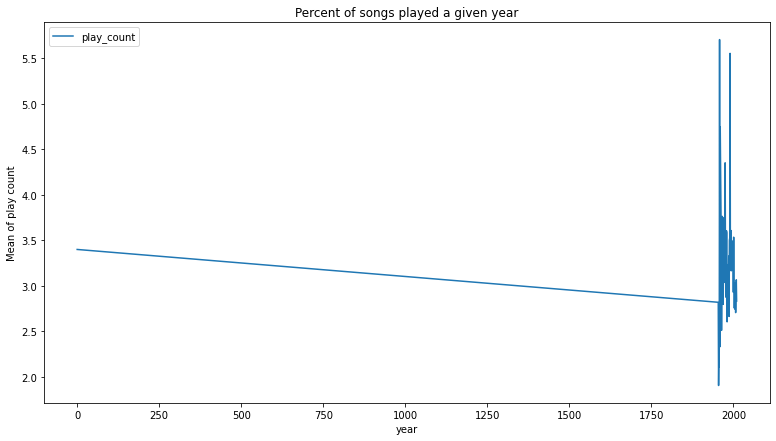

In [133]:
# line graph displaying play_count given each year by mean 
mean_df = df_final.groupby(['year']).mean()

listen_count_trend = mean_df[['play_count']].plot.line(figsize=(13,7))
listen_count_trend.set_ylabel('Mean of play count')
listen_count_trend.set_title('Percent of songs played a given year')

**Observatinos**
- The graph suggests that many users interacted with song listens during ~1995-2010 years. 
- There is a vast number of users listening to music around the 1995 mark and another similarly vast amount of users listening to music around the 2010 mark. 

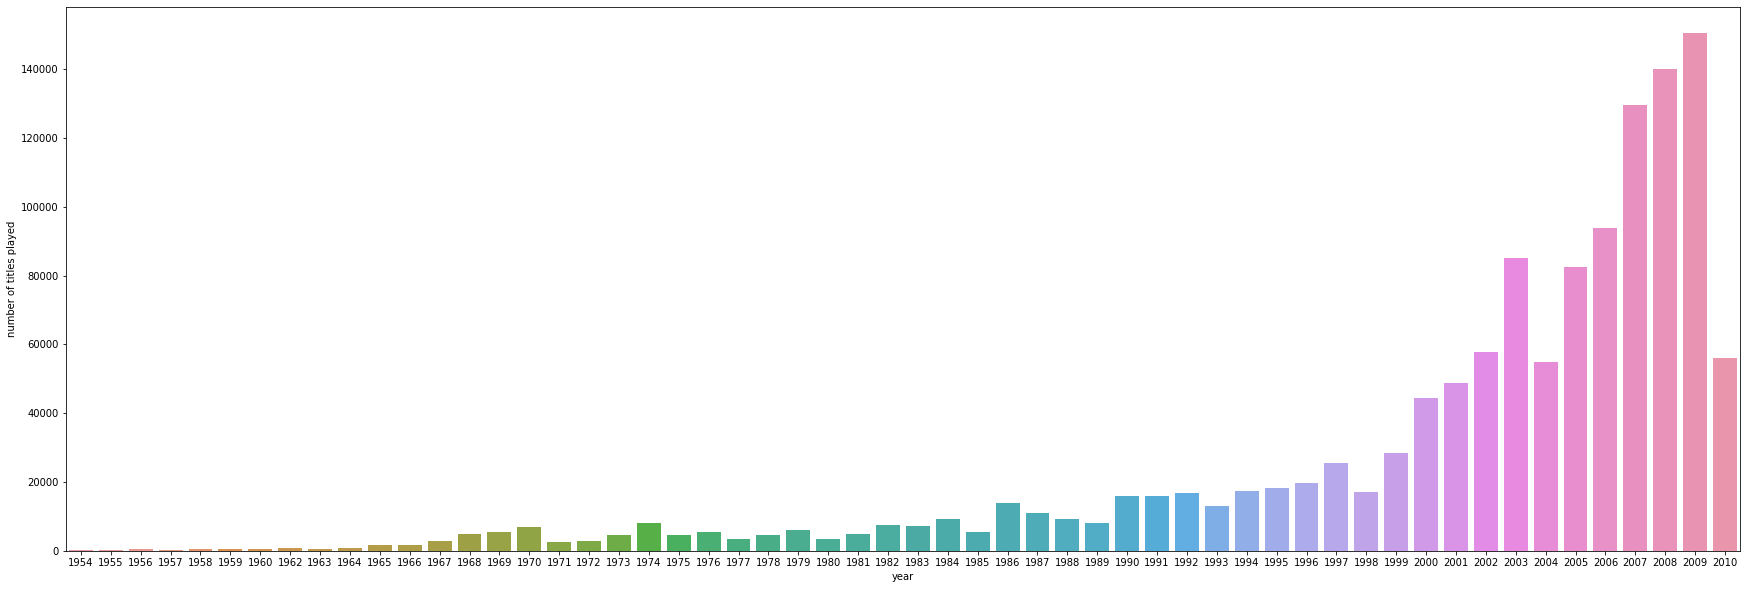

In [337]:
plt.figure(figsize=(30,10))
sns.barplot(x = count.index,
            y = 'play_count',
            data = count,
            estimator = np.median)
plt.ylabel('number of titles played') 
# Show the plot
plt.show()

**Observations**

- Interestingly, initial assumption of 2010 being the highest play count of song is incorrect.

In [134]:
# filter data to show the most recent releases
this_year = df_final.loc[(df_final['year']==2010)]

# check if there are songs from the year 2010
this_year['year'].value_counts()

2010    56084
Name: year, dtype: int64

**Observations** 
- Explicitly, there were ~56084 users listening to songs in our dataset during the 2010 years. 

**Checking the number of unqiue users in the dataset**

In [135]:
# number of unique users in the dataset 
print('Number of unique USERS in the Raw data = ', df_final['user_id'].nunique())
print('Number of unique SONGS in Raw data = ', df_final['song_id'].nunique())

Number of unique USERS in the Raw data =  75579
Number of unique SONGS in Raw data =  5229


**Observations**
- There are a lot of unique values in our dataset. 

**Users with an appropriate number of song listen counts**


In [136]:
# top 10 users based on listen count of song(s)
most_listened = df_final.groupby('user_id').size().sort_values(ascending=False)[:10]
most_listened

user_id
75144    537
32542    518
61472    446
10807    435
31704    427
23297    424
23790    406
48273    401
6480     391
49507    389
dtype: int64

**Observations**
- The top ten users with the highest counts listened to a song are: [75144, 32542, 61472, 10807, 31704, 23297, 23790, 48273,  6480, 49507]

##### **Data preparation**

In [137]:
# check the number of unique USERS and SONGS in the final data and provide observations

print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['user_id'].nunique())
print('Number of unique SONGS in the final data = ', df_final['song_id'].nunique())
print('Number of COUNTS LISTENED in the final data = ', df_final['play_count'].sum)

The number of observations in the final data = 1575883
Number of unique USERS in the final data =  75579
Number of unique SONGS in the final data =  5229
Number of COUNTS LISTENED in the final data =  <bound method NDFrame._add_numeric_operations.<locals>.sum of 0          1
1          2
2          1
3          1
4          1
          ..
1999994    4
1999995    2
1999996    4
1999997    3
1999998    1
Name: play_count, Length: 1575883, dtype: int64>


**Observations**
- The number of observations in the final data = 1575883
- Number of unique USERS in the final data =  75579
- Number of unique SONGS in the final data =  5229

##### **Data Normalization**

In [44]:
zscore = lambda x: (x-x.mean())/x.std()
the_norm_zscore = df_final.groupby('user_id').transform(zscore)
df_final.play_count = the_norm_zscore.play_count

df_final.head()

,user_id,song_id,play_count,title,release,artist_name,year
0,54961,17370,-0.360085,The Cove,Thicker Than Water,Jack Johnson,0
1,54961,45995,0.240056,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,54961,82002,-0.360085,Stronger,Graduation,Kanye West,2007
3,54961,83689,-0.360085,Constellations,In Between Dreams,Jack Johnson,2005
4,54961,129375,-0.360085,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


In [45]:
min_max = lambda x: (x - x.min()) / (x.max() - x.min())
the_norm_min_max = df_final.groupby('user_id').transform(min_max)
df_final.play_count = the_norm_min_max.play_count 

df_final.head()

,user_id,song_id,play_count,title,release,artist_name,year
0,54961,17370,0.000000,The Cove,Thicker Than Water,Jack Johnson,0
1,54961,45995,0.142857,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,54961,82002,0.000000,Stronger,Graduation,Kanye West,2007
3,54961,83689,0.000000,Constellations,In Between Dreams,Jack Johnson,2005
4,54961,129375,0.000000,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


In [46]:
df_final.fillna(value=0)

,user_id,song_id,play_count,title,release,artist_name,year
0,54961,17370,0.000000,The Cove,Thicker Than Water,Jack Johnson,0
1,54961,45995,0.142857,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,54961,82002,0.000000,Stronger,Graduation,Kanye West,2007
3,54961,83689,0.000000,Constellations,In Between Dreams,Jack Johnson,2005
4,54961,129375,0.000000,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999
...,...,...,...,...,...,...,...
1999994,64590,359346,0.375000,Unwell (Album Version),More Than You Think You Are,matchbox twenty,2003
1999995,64590,385009,0.125000,Ignorance (Album Version),Ignorance,Paramore,0
1999996,64590,392598,0.375000,Two Is Better Than One,Love Drunk,Boys Like Girls featuring Taylor Swift,2009
1999997,64590,393702,0.250000,What I've Done (Album Version),What I've Done,Linkin Park,2007


##### **Word2vec Recommendation System**


**Data Preparation**

In [47]:
# transfrom song_id to string types
df_final['song_id']= df_final['song_id'].astype(str)

In [48]:
# check the number of unique song listeners in the dataset
users = df_final['user_id'].unique().tolist()
len(users)

75579

In [49]:
# set 90% of the users as a sample of the dataset for validation

# shuffle user_id
random.shuffle(users)

# set aside 90% of the user_id
user_train = [users[i] for i in range(round(0.9*len(users)))]

# split df_final into train and test sets 
train_df_final = df_final[df_final['user_id'].isin(user_train)]
test_df_final = df_final[~df_final['user_id'].isin(user_train)]

In [50]:
# create sequence of play_count made by user_id in the dataset for both train and test sets

# list for song play_count training set
play_count_train = []

# populate the list with song_id
for i in tqdm(user_train): 
    temporary = train_df_final[train_df_final['user_id'] == i]['song_id'].tolist()
    play_count_train.append(temporary)

100%|██████████| 68021/68021 [04:07<00:00, 275.12it/s]


In [51]:
len(play_count_train)

68021

In [52]:
# list for song play_count testing set
play_count_test = []

# populate the list with song_id
for i in tqdm(test_df_final['user_id'].unique()):
    temporary = test_df_final[test_df_final["user_id"] == i]["song_id"].tolist()
    play_count_test.append(temporary)

100%|██████████| 7558/7558 [00:11<00:00, 664.77it/s]


In [53]:
len(play_count_test)

7558

In [54]:
# train word2vec model

train_word2vec_model = Word2Vec(window=10, 
                                sg=1, 
                                hs=0,
                                negative=10, 
                                alpha=0.03, 
                                min_alpha=0.0007,
                                seed=14) 

train_word2vec_model.build_vocab(play_count_train,progress_per=200)

train_word2vec_model.train(play_count_train, 
                            total_examples=train_word2vec_model.corpus_count, 
                            epochs=10,
                            report_delay=10)


(14025427, 14150090)

In [55]:
# use init_sims() to make the model memory efficient
train_word2vec_model.init_sims(replace=True)

In [56]:
# summarize the model 
print(train_word2vec_model)

Word2Vec(vocab=5229, size=100, alpha=0.03)


**Observations** 
- The model has 5229 unique words with a vector size of 100. 
- The words need to be extracted and stored. 

In [57]:
# take the vectors and store them
words = train_word2vec_model[train_word2vec_model.wv.vocab]
words

words.shape

(5229, 100)

In [58]:
# fit a 2d PCA model to the vectors
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca

PCA(n_components=2)

In [59]:
results = pca.fit_transform(words)

##### **Map the Embeddings**

**Dimensional reduction: reduce the dimensions of the song_id embeddings"

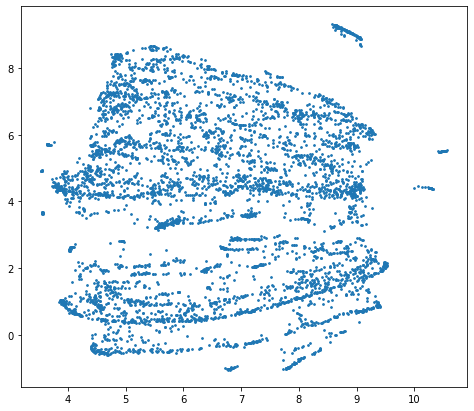

In [60]:
# reduce the dimensions of the song embeddings from 100 to 2
embedded_cluster = umap.UMAP(n_neighbors=30, 
                            min_dist=0.0,
                            n_components=2, 
                            random_state=42).fit_transform(words)

plt.figure(figsize=(8,7))
plt.scatter(embedded_cluster[:, 0], embedded_cluster[:, 1], s=3, cmap='Spectral')

**Observations**
- The points on the graph are a single song. 
- The embedding clusters on the graph are groups of similar songs. 

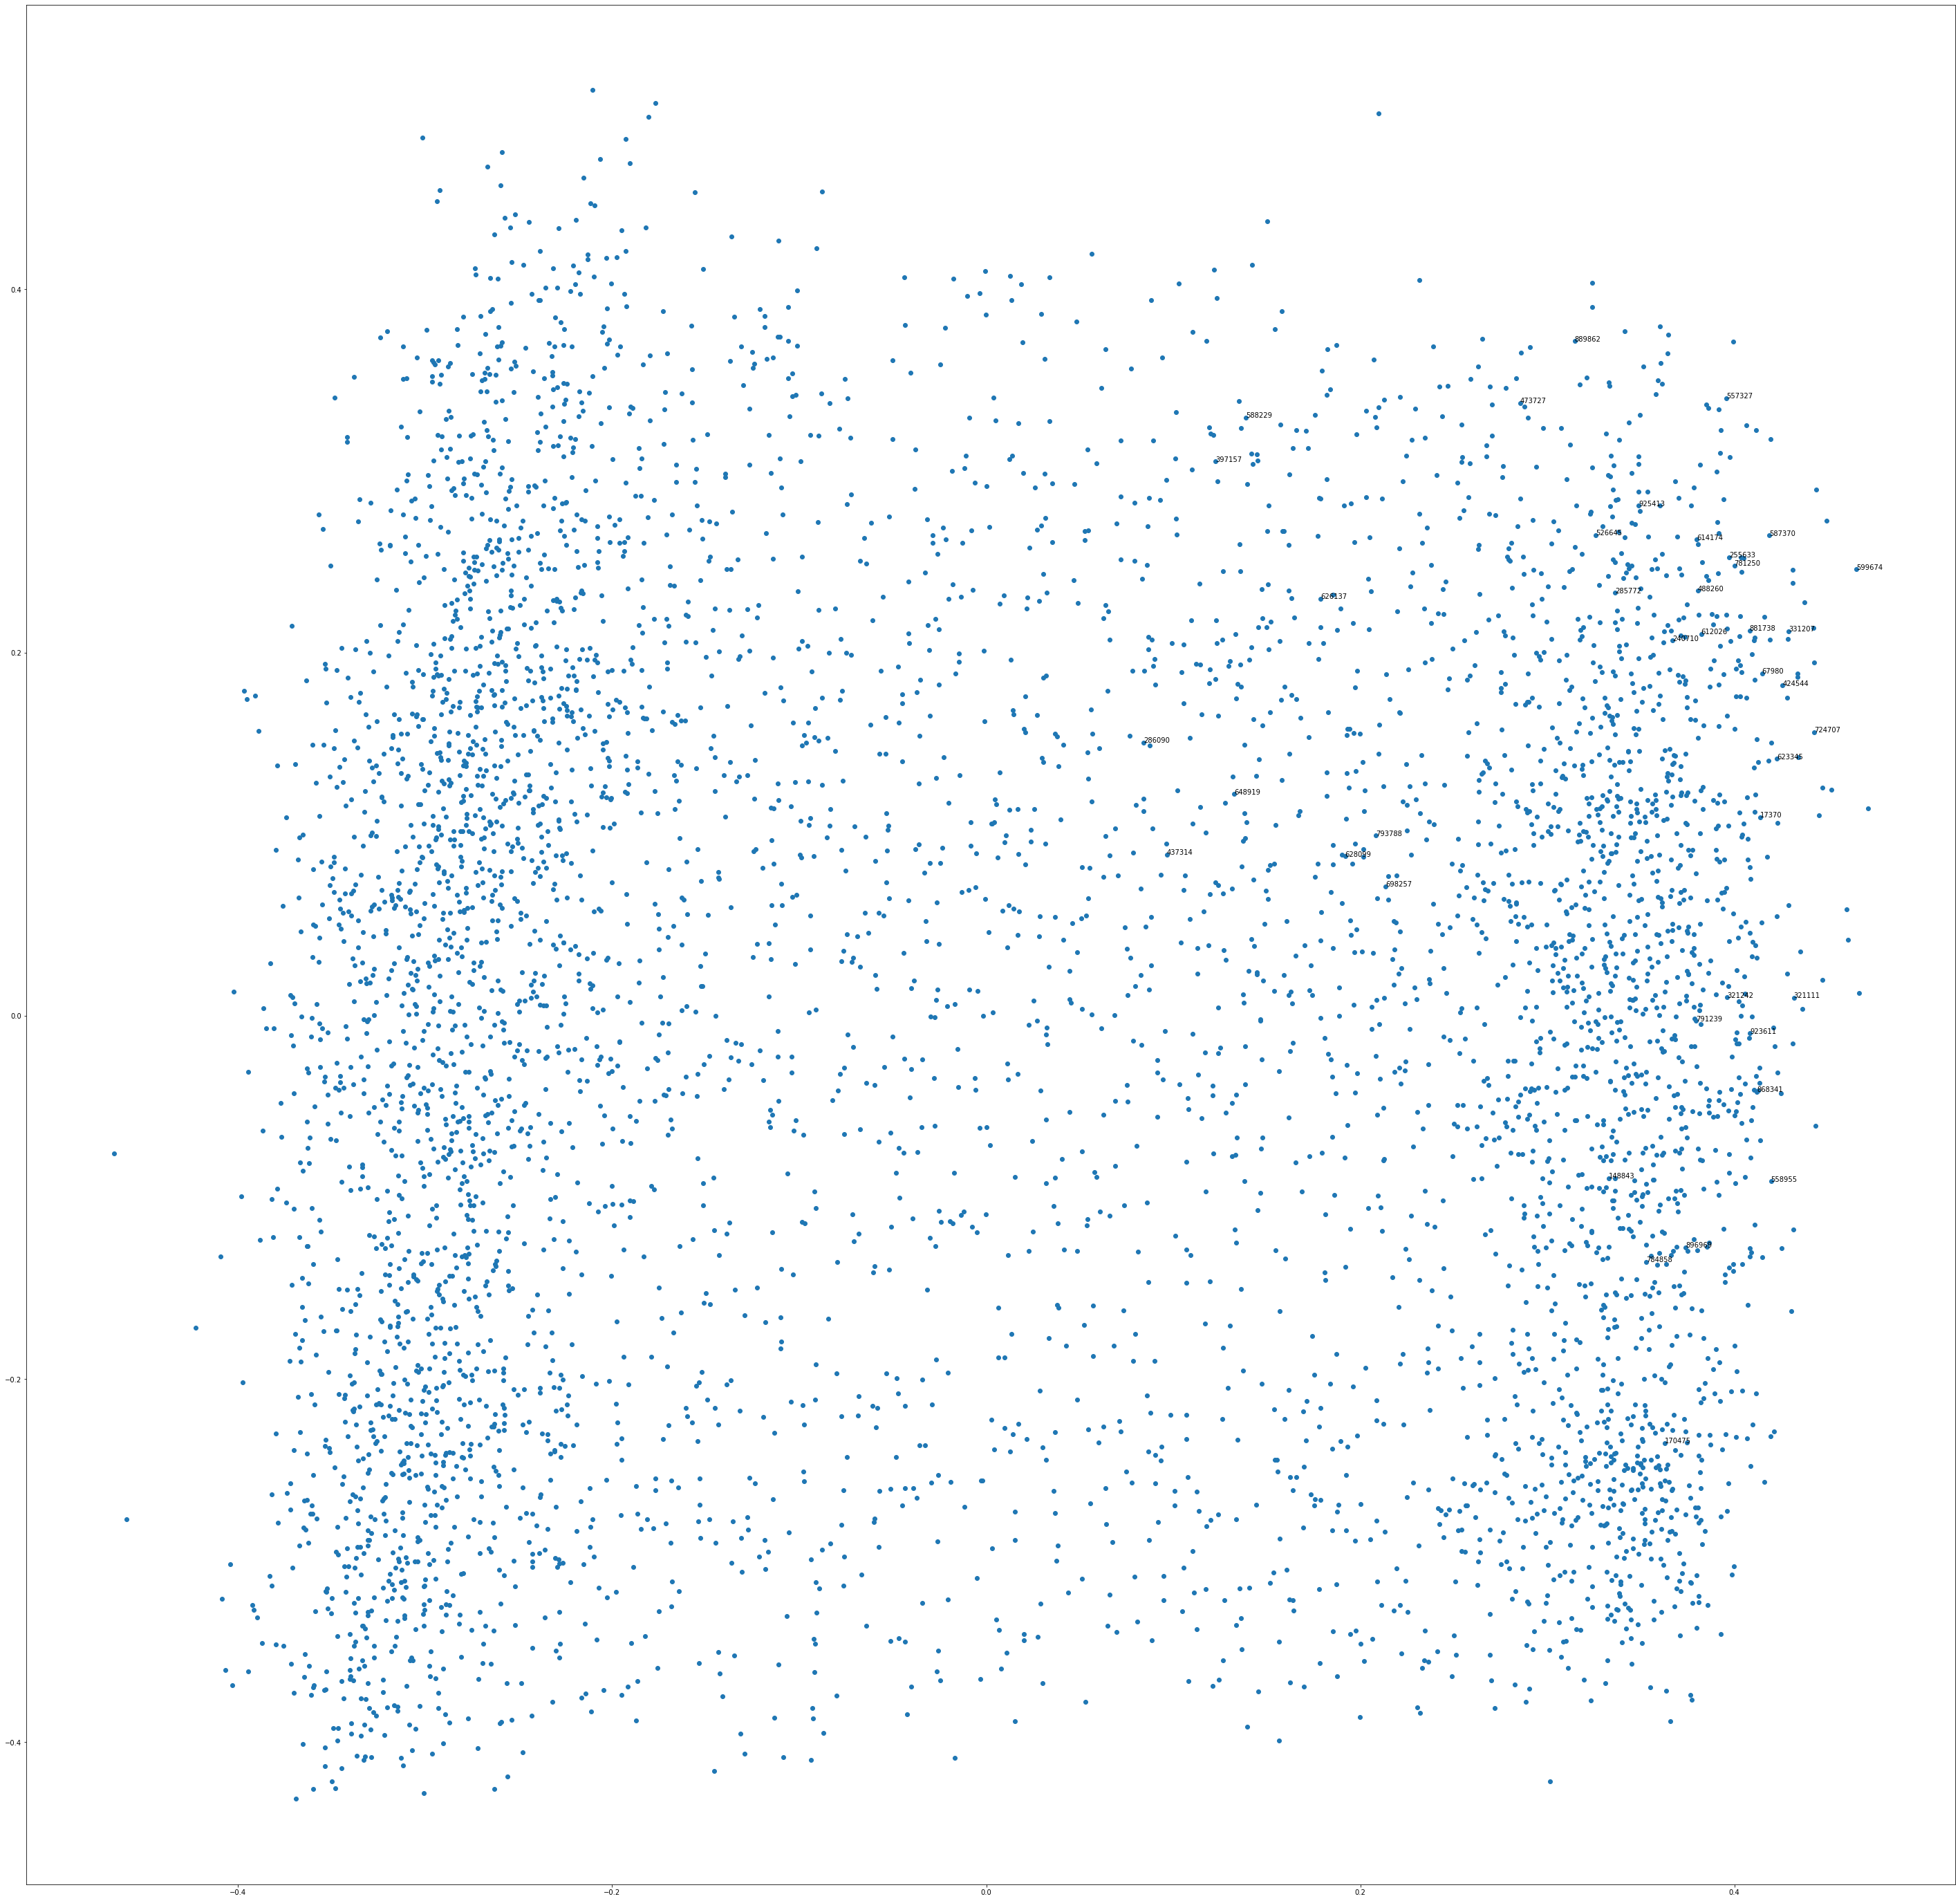

In [61]:
# graph songs on a scatter plot 
from matplotlib import pyplot
from random import sample

pyplot.figure(figsize=(50,50))
pyplot.scatter(results[:, 0], results[:, 1])
words = list(train_word2vec_model.wv.vocab)
sample_words = sample(words, 40)
for i, word in enumerate(sample_words):
	pyplot.annotate(word, xy=(results[i, 0], results[i, 1]))
pyplot.show()

**Observations** 
- The scatter plot is nonlinear, has zero slope and is weak (in association). 
- Correlations for songs are nonlinear. 
- Outliers are predominantly present at the top of the graph. 
- There are some outliers also at the bottom of the graph. 
- The points are widely spread apart in the middle, which indicates there is high variability in the data around the center. 
- On the left side and right sides of the graph, the observations are clustered around many, single values, which indicates that the variability spread on the left and right sides is smaller for the song correlations.
- Since there is such spread in the graph, the weaker the relationship among the songs in the middle of the graph. 
- For the left and right sides of the graph, the spread is smaller, indicating a stronger relationship among songs. 


##### Word2vec Recommending songs


In [62]:
# create a song id to map the songs' titles 
songs = train_df_final[['song_id', 'title']]

In [63]:
train_df_final.head()

,user_id,song_id,play_count,title,release,artist_name,year
0,54961,17370,0.000000,The Cove,Thicker Than Water,Jack Johnson,0
1,54961,45995,0.142857,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,54961,82002,0.000000,Stronger,Graduation,Kanye West,2007
3,54961,83689,0.000000,Constellations,In Between Dreams,Jack Johnson,2005
4,54961,129375,0.000000,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


In [64]:
# drop duplicates on song_id
songs.drop_duplicates(inplace=True, subset='song_id', keep="last")

In [333]:
# group songs by their id and title and store into a dictionary 
song_dictionary = songs.groupby('song_id')['title'].apply(list).to_dict()

In [66]:
song_df.head()

,song_id,title,release,artist_name,year
0,664054,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,834264,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,286654,No One Could Ever,Butter,Hudson Mohawke,2006
3,66717,Si Vos Querés,De Culo,Yerba Brava,2003
4,324820,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0


In [67]:
song_dictionary['100511']

['Whoomp! There It Is']

In [68]:
# function that inputs song vectors and returns 10 similar songs
def similar_songs(vctr, n = 10): 
    most_similar = train_word2vec_model.similar_by_vector(vctr, topn=n+1)[1:]
    updated_most_similar = []
    for similar in most_similar: 
        song_pairs = (song_dictionary[similar[0]][0], similar[1])
        updated_most_similar.append(song_pairs)
    return updated_most_similar

In [69]:
similar_songs(train_word2vec_model['100511'])

[('Ice Ice Baby (Radio Edit)', 0.7445834875106812),
 ('Decades Of Despair', 0.7296344041824341),
 ("My Lovin' (You're Never Gonna Get It) (LP Version)", 0.7189461588859558),
 ('MMMBop', 0.7093039751052856),
 ('Lovefool', 0.708886981010437),
 ("Breakfast At Tiffany's", 0.7068742513656616),
 ('Killing Me Softly With His Song', 0.7049561738967896),
 ('Stay', 0.691421627998352),
 ('Bust A Move', 0.6861682534217834),
 ('Jack & Diane', 0.6833891868591309)]

**Observations**
- The song that was most similar by ~76.5% is Ice Ice Baby.
- The songs are recommended from various different years 1990-2008. The release date/year does not seem to affect the recommender that the song is more or less modern. 
- Song recommendations appear to be top hits for the artists' who wrote them and involve concepts of extreme emotion: bliss, failing relationships, depression/sadness, forgiveness. 
- It is evident that there are groups of recommended songs based on their percentage of similarity. 
    * Songs with concepts of futility of relationships/sadness related to romantic relationships: 'Para Hacerme Perdonar (En Vivo Teatro Metropolitan)', 0.7175484895706177), ('Lovefool', 0.7157837152481079), 'Blue (Da Ba Dee)', 0.7192554473876953). 
    * Songs with concepts of love for a woman/foregiveness/broken relationships for a woman(s): "My Lovin' (You're Never Gonna Get It) (LP Version)", 0.706565260887146), 'Your Woman', 0.7055498361587524)
    * Songs with concpets of depression/sadness/death/futility of life:  'Killing Me Softly With His Song', 0.6861705183982849), 'MMMBop', 0.6831271648406982), 'Decades Of Despair', 0.6998589038848877). 
- The Word2vec model seems to take two analogies and mirror them into an association. 
    * Depression/Death by depression : Blue (Da Ba Dee)  - Killing Me Softly With His Song = Decades of Despair. 


**Song breakdowns**
- In the 1990s, "Ice Ice Baby" was the very first single by a rapper to top the American Billboard charts. Ice says that he wrote the lyrics in 30 minutes, and they the are based in fact. He told Entertainment Weekly in 2016: "The song tells you the story. It's me, with my top down, in my 5.0 Mustang, cruising down A1A Beachfront Avenue. It's a weekend experience that turned into an amazing song. It's timeless. I still love singing it, and it never gets old."
- "Breakfast at Tiffany's" is a song by American alternative rock band Deep Blue Something. The song was the band's only hit, peaking at number five on the US Billboard Hot 100. The song is a humorous and optimistic look at a failing relationship. One partner focuses on how different the two people are and how they aren't going to last as a couple.
- "Blue (Da Ba Dee)" is the group's most popular single, reaching number one in 17 countries, charting at number two in Italy, and peaking at number six on the US Billboard Hot 100 in January 2000. Different colors have represented different emotions over time but the color blue has been attributed to the feeling of sadness which makes this song possibly about depression.
- 'Para Hacerme Perdonar (En Vivo Teatro Metropolitan)' is the fifth album and first live album by Mexican singer-songwriter Ely Guerra . The album was recorded live at the Teatro Metropólitan in Mexico City during a presentation in 2006 and was released on sale on February 17, 2007. It appears to be a song about an emotional plea for forgiveness from a lover. 
- "Lovefool" was the song that propelled the Cardigans to international stardom. Nina Persson penned the lyrics for this song, while guitarist Peter Svensson wrote the music. She told STIM (The Swedish Performing Rights Society): "I do find that the biggest hits are the ones that are the easiest to write."
- "MMBop", "What that song talks about is, you've got to hold on to the things that really matter. MMMBop represents a frame of time or the futility of life. Things are going to be gone, whether it's your age and your youth, or maybe the money you have, and all that's going to be left are the people you've nurtured and have really built to be your backbone and your support system."

In [70]:
# function that takes the average of all song vectors and returns similar songs
def average_of_vectors(songs): 
    song_vector = []
    for song_item in songs: 
        try:
            song_vector.append(train_word2vec_model[song_item])
        except KeyError: 
            continue
    return np.mean(song_vector, axis=0)

In [71]:
# length of the list of songs listened to by a user
len(play_count_test[0])

12

**Observations** 
- The average number of songs that a user listens to from the dataframe is 12. 

In [72]:
# the original vector_size is 100
average_of_vectors(play_count_test[0]).shape

(100,)

**Observations**
- The vector_size and average of all vectors is equal to 100. This indicates that the model is correctly applying the vector sizing.

In [73]:
# most similar songs based on the average of vectors
similar_songs(average_of_vectors(play_count_test[0]))

[('Crack A Bottle', 0.7387005090713501),
 ('The Real Slim Shady', 0.7338780164718628),
 ("My Dad's Gone Crazy", 0.7296184301376343),
 ('Whatcha Say', 0.721392035484314),
 ('Superman', 0.7148323059082031),
 ('Mockingbird', 0.7141843438148499),
 ('Just Lose It', 0.7130401134490967),
 ('Drop It Low', 0.7044399976730347),
 ('All I Do Is Win (feat. T-Pain_ Ludacris_ Snoop Dogg & Rick Ross)',
  0.6887338757514954),
 ('Say What You Say', 0.68509441614151)]

In [74]:
# last ten similar songs listened to by a user 
similar_songs(average_of_vectors(play_count_test[0][-10:]))

[('Just Lose It', 0.7692992687225342),
 ('Whatcha Say', 0.7340867519378662),
 ('The Real Slim Shady', 0.7279930114746094),
 ('Drop It Low', 0.7166177034378052),
 ('16 Candles', 0.7138705849647522),
 ('All I Do Is Win (feat. T-Pain_ Ludacris_ Snoop Dogg & Rick Ross)',
  0.7005053758621216),
 ('Crack A Bottle', 0.700504720211029),
 ('Rock Star', 0.6900161504745483),
 ('Toxic', 0.6831427812576294),
 ("Nothin' On You [feat. Bruno Mars] (Album Version)", 0.6802244186401367)]

**Observations**
- Last 10 songs and the 10 most similar songs are the same when using this training recommender for average of vectors model.
- The recommended songs involve less thematic grouping. It seems, the songs recommended, are more widely ranging from rap to indietronica. 
- 'Streets On Lock', received an ~87.74% similarity rating among user songs. It's a rap and with heavy beats involving
- 'What They Found' is an indietronica and received ~79.43% in similarity. By the same artist, 'Hypnopaedia', received ~79.29% similarity recommendation. 
- It indicates that the word2vec model needs a lot more training and a lot more data. 

### **Item-Based Collaborative Filter**

Building an item based collaborative filtering reccommender using SciKitLearn's NearestNeighbors class. The approach is to create list of each user's songs and use other user's data to generate reccommendatinos for the first user. 

In [166]:
from scipy import sparse
from sklearn.neighbors import NearestNeighbors

In [254]:
# create a matrix of the users' played songs, ignoring the play count
users_songs = df_final[['user_id', 'song_id']]
users_songs_matrix = users_songs.to_numpy()
users_songs_matrix

array([[ 54961,  17370],
       [ 54961,  45995],
       [ 54961,  82002],
       ...,
       [ 64590, 392598],
       [ 64590, 393702],
       [ 64590, 409426]])

In [255]:
# returns the transpose of the matrix
keys, values = users_songs_matrix.T

# used later when retrieving the songs from the reccomendatinos
unique_songs = df_final.song_id.unique()

# Creating a new numpy matrix A which will have rows of users and columns of songs
# The entries will be a 1 if the user listened to this song, 0 otherwise
rows, row_idx = np.unique(keys, return_inverse=True)
cols, col_idx = np.unique(values, return_inverse=True)

A = np.zeros((len(rows), len(cols)), dtype=np.int)
A[row_idx, col_idx] = 1

In [256]:
# how many unique songs the user at index 0 listened to
A[0].sum()

4

In [332]:
# the total number of non-zero entries in the matrix, should equal the number of rows in the user_song pairings matrix
sum_matrix_a = A.sum()
assert sum_matrix_a == len(users_songs_matrix)

In [320]:
# create a sparse matrix from the full matrix
# the original matrix is mostly empty
size_of_matrix = len(rows)*len(cols)
density = sum_matrix_a / size_of_matrix
print("Matrix A density: {}".format(density))

# the same calculations below this can be completed but the sparse matrix is a compacted form, it doesn't contain the zeros, only the ones
csr_sample = sparse.csr_matrix(A)


Matrix A density: 0.0039875320554262255


In [315]:
import sys

print("Size of original matrix (bytes): {}".format(sys.getsizeof(A)))
print("Size of sparse matrix (bytes): {}".format(sys.getsizeof(csr_sample)))

Size of original matrix (bytes): 3161620856
Size of sparse matrix (bytes): 48


In [259]:
# fit a scikit liearn NearestNeighbors model based on users that also listened to this song, predicting songs that they listed to
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=11, n_jobs=-1)
knn.fit(csr_sample)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=4)

In [330]:
# reccommend 10 similar songs from song 
chosen_song_id = 538595
song_index = np.where(users_songs_matrix == chosen_song_id)[0][0]

# get the distances and indicies from the trained model
distances , indices = knn.kneighbors(csr_sample[song_index],n_neighbors=11)
# using only the indicies, flatten to make easier to work with
indices = indices.flatten()
# lookup the original song_id from the users_songs_matrix
song_indicies = [users_songs_matrix[index][1] for index in indices]
print(song_indicies)
# display the information about the closest songs in the nearest neighbors model
print(df_final.loc[df_final['song_id'].isin(song_indicies[:1]), ['song_id', 'title', 'release', 'artist_name', 'year']].drop_duplicates(['song_id']))
df_final.loc[df_final['song_id'].isin(song_indicies[1:]), ['song_id', 'title', 'release', 'artist_name', 'year']].drop_duplicates(['song_id'])

[538595, 941905, 78831, 553599, 326718, 816989, 335268, 242056, 546282, 100511, 181663]
      song_id             title      release artist_name  year
4718   538595  Windmill Wedding  No Way Down  Air France  2008


,song_id,title,release,artist_name,year
95,181663,Horn Concerto No. 4 in E flat K495: II. Romanc...,Mozart - Eine kleine Nachtmusik,Barry Tuckwell/Academy of St Martin-in-the-Fie...,0
205,78831,Monkey Man,You Know I'm No Good,Amy Winehouse,2007
3080,553599,Lithium,Nevermind,Nirvana,1996
4947,335268,Break My Body,Demos,Pixies,1987
6794,326718,Jerry Was A Race Car Driver,Sailing The Seas Of Cheese,Primus,1991
7457,816989,Bold As Love,Continuum,John Mayer,0
11337,242056,Y solo se me ocurre amarte (Unplugged),Grandes exitos 1991-2004,Alejandro Sanz,0
17657,546282,Comatose (Comes Alive Version),Comatose Comes Alive [Deluxe],Skillet,0
27880,941905,Posters,Brushfire Fairytales,Jack Johnson,2000
34030,100511,Whoomp! There It Is,Push It!,Tag Team,1994


### **Simple Recommender**


In [76]:
from IPython.display import display
# function that groups songs by title and play_count with percentage of song counts listened
def group_songs_by_play_count():
    grouped_songs_df = df_final.groupby(['title']).agg({'play_count': 'count'}).reset_index()
    grouped_songs_sum = grouped_songs_df['play_count'].sum()
    grouped_songs_df['percentage'] = grouped_songs_df['play_count'].div(grouped_songs_sum)*100
    final_grouped_songs_df = grouped_songs_df.sort_values(['play_count', 'title'], ascending = [0,1])
    display(final_grouped_songs_df)
group_songs_by_play_count()

,title,play_count,percentage
3636,Sehr kosmisch,8056,0.527471
4636,Undo,6869,0.449751
1022,Dog Days Are Over (Radio Edit),6748,0.441829
5050,You're The One,6586,0.431222
3456,Revelry,6005,0.393180
...,...,...,...
4930,Wire To Wire,111,0.007268
2541,Love Like Honey (amended album version),110,0.007202
3305,Porchrail,110,0.007202
4865,Where Corn Don't Grow,110,0.007202


**Observations** 
- The top 5 songs that had a high percentage of play counts: Sehr kosmisch, Undo, Dog Days Are Over (Radio Edit), You're The One, Revelry
- It will be interesting to see if these songs are recommended again using a different recommender system. 
- The Word2vec and Collaborative recommenders did not recommend any of the titles above. 

In [77]:
# calculate the average play_count for each song 
average_rating = df_final.groupby('song_id').mean()['play_count']

In [78]:
# calculate the count of play_count for each song
count_rating = df_final.groupby('song_id').count()['play_count']

In [79]:
# create a dataframe with calculated average and count of play_count
final_rating = pd.DataFrame({'avg_play_count':average_rating, 'play_count':count_rating})

In [80]:
# sort the dataframe by average of play_count in the descending order
final_rating = final_rating.sort_values(by='avg_play_count', ascending=False) 

In [81]:
final_rating.head(20)

,avg_play_count,play_count
song_id,,
3743,0.534310,156
284055,0.516810,134
842729,0.505630,224
406335,0.499071,257
851645,0.467486,120
249495,0.449645,125
257781,0.449088,160
694054,0.430271,198
371053,0.400183,124


In [82]:
# define a function to get the top n songs based on highest average play count and minimum count listens
def top_n_products(final_rating, n, min_interaction=50):
    # find songs with minimum number of play counts
    recommendations = final_rating[final_rating['play_count'] > min_interaction]
    # sort values w.r.t average play count 
    recommendations = recommendations.sort_values(by='avg_play_count', ascending=False)

    return recommendations.index[:n]

In [83]:
# recommend top 10 songs with 50 minimum interactions based on play counts popularity
list(top_n_products(final_rating, 10, min_interaction=50))

['3743',
 '284055',
 '842729',
 '406335',
 '851645',
 '249495',
 '257781',
 '694054',
 '371053',
 '918304']

In [84]:
# recommend top 10 songs with 100 minimum interactions based on play counts popularity
list(top_n_products(final_rating, 10, min_interaction=100))

['3743',
 '284055',
 '842729',
 '406335',
 '851645',
 '249495',
 '257781',
 '694054',
 '371053',
 '918304']

**Observations**
- The majority of the song_id are the same between both recommendations. 
- The songs that are not the same for both recommendations are : 791443, 624743, 538682, 851645
- The songs that are the same : 3743, 217352, 985375, 406335, 918304, 22807, 284055, 249495

**Building a baseline user user similarity based recommendation system
This is a similarity-based recommendation systems using cosine similarity and using KNN to find similar users which are the nearest neighbor to the given user.**

#### **ADDITIONAL THOUGHTS**
**Rank-Based Recommendation System**
**To build the rank-based recommendation system, take the average of all the listen counts provided to each user and then rank them based on their average listen count**



In [85]:
# calculate average listen counts
average_listen_counts = df_final.groupby('user_id').mean()['play_count']

# calculate the count of listens 
count_of_listen = df_final.groupby('user_id').count()['play_count']

# make a dataframe with the count and average of listens for a user
final_listen_df = pd.DataFrame({'avg_listen_counts':average_listen_counts, 'listen_count': count_of_listen})

#df_final['user_id'].drop_duplicates().sort_values()

In [86]:
m = df_final.groupby('user_id').quantile(0.90)['play_count']

In [87]:
final_listen_df.head(100)

,avg_listen_counts,listen_count
user_id,,
0,0.500000,4
1,NaN,0
2,0.312500,8
3,0.450000,8
4,NaN,0
...,...,...
95,0.166667,6
96,0.172932,19
97,0.140523,34


In [88]:
# function for top n users for a recommendation based on average ratings of restaurant
def top_n_user(df_final, n, min_interaction=50): 
    
    # find users with minimum number of interactions
    recommendations = df_final[df_final['listen_count'] > min_interaction]
    
    # sort values w.r.t average listen counts 
    recommendations = recommendations.sort_values(by='avg_listen_counts', ascending=False)
    
    return recommendations.index[:n]

**Recommending top 5 songs with 50 minimum interacitons based on play count(s)**

In [89]:
list(top_n_user(final_listen_df, 5, 50))

[74442, 64859, 22737, 72504, 49639]

**Observations**
- For the top n users with a minimum interaction of 50 listens the songs that were recommended: [74442, 64859, 22737, 72504, 49639]

**Recommending top 5 songs with 100 minimum interacitons based on play count(s)**

In [90]:
list(top_n_user(final_listen_df, 5, 100))

[36992, 8092, 70362, 30502, 33493]

**Observations**
- For the top n users with a minimum interaction of 100 listens the songs that were recommended: [[36992, 8092, 70362, 30502, 33493]
- The song_id have declined. 

##### **Data Reduction**

In [91]:
# get the column containing the users
users = merged_df.user_id
# create a dictionary from users to their number of songs
ratings_count = dict()

# function to filter the data for users who have listened to a good count of songs
def sufficient_count_of_songs(): 
    for user in users:
    # if there already exists a user, just add 1 to the rating count
        if user in ratings_count:
            ratings_count[user] += 1
    # otherwise, set the rating count to 1
        else:
            ratings_count[user] = 1 
    some_ratings_count = list(ratings_count)[:200]
    print(some_ratings_count)
sufficient_count_of_songs()

[54961, 39877, 56522, 40874, 45012, 22570, 66678, 47087, 46575, 54498, 6958, 63855, 27018, 59353, 20639, 70730, 55837, 6647, 50286, 56576, 3204, 38632, 19147, 74048, 48241, 19194, 13178, 42347, 57055, 5416, 49549, 44537, 12898, 58003, 18808, 43278, 70892, 73298, 9415, 21487, 76143, 63872, 359, 24533, 20082, 43942, 34420, 60317, 53867, 12635, 33130, 68660, 45949, 35629, 49202, 54615, 49608, 38327, 45988, 70816, 75935, 34234, 3540, 18971, 7798, 49235, 72300, 65206, 22784, 41940, 17679, 58071, 384, 47801, 29430, 7952, 54091, 72841, 9670, 37560, 69683, 6937, 54439, 35957, 19076, 44618, 2282, 38800, 26436, 54164, 6285, 30346, 25492, 44689, 15550, 14046, 47803, 70178, 25651, 70000, 52925, 44648, 22447, 6872, 42650, 37000, 24267, 53923, 56544, 21274, 40553, 39887, 27881, 68345, 58076, 19568, 6888, 4351, 70647, 17831, 40583, 64176, 40543, 46525, 17192, 49395, 55758, 37086, 68099, 42302, 24524, 28077, 68048, 41638, 7320, 75095, 57655, 69800, 4383, 10723, 66723, 12383, 39814, 10374, 69499, 56100